In [379]:
import pickle
import sklearn
import math
import itertools
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
pub = pd.read_pickle("./pub_auth.pickle")

In [3]:
# Discard single authored
print pub.count()
pub = pub[pub["AUTHORS"].apply(lambda x: len(x)) > 1]
pub = pub[pub["AUTHORS"].apply(lambda x: len(x)) < 4]
print pub.count()

AUTHORS             29663
PUBLICATION_YEAR    29663
dtype: int64
AUTHORS             7582
PUBLICATION_YEAR    7582
dtype: int64


In [4]:
authors = []
for i in pub["AUTHORS"]:
    authors += list(i)
authors = list(set(authors))
authors.sort()

In [5]:
years = []
for i in pub["PUBLICATION_YEAR"]:
    if i not in years:
        years.append(i)
years.sort()

In [6]:
years

[2008, 2009, 2010, 2011, 2012, 2013]

In [7]:
connections = pd.DataFrame(index=authors, columns=authors)
connections = connections.fillna(0.0)

connections_yearly = {}
for y in years:
    connections_yearly[y] = connections.copy()
connections_yearly["total"] = connections.copy()

In [8]:
# define learning rate
def lr(year, alpha_zero=0.5, year_min=2000, year_max=2020, year_factor=95.0):
    if year < year_min:
        print "Error: it's too early!"
        raise None
    elif year > year_max:
        print "Error: it's too late!"
        raise None
    elif year == year_min:
        return alpha_zero
    else:
        return lr(year-1) * (1+(year-year_min)/year_factor)

In [9]:
x = range(2002, 2015)
y = [lr(i) for i in x]
xy_cmap = ["red" if i in years else "blue" for i in x]

llr = {}
for xi, yi in zip(x, y):
    llr[xi] = yi
llr[0] = 0.5
llr

{0: 0.5,
 2002: 0.5159002770083103,
 2003: 0.5321918647033096,
 2004: 0.5545999432171331,
 2005: 0.5837894139127717,
 2006: 0.6206603242651573,
 2007: 0.6663931902636425,
 2008: 0.7225105115490019,
 2009: 0.7909588758010127,
 2010: 0.8742177048326981,
 2011: 0.9754429127606946,
 2012: 1.0986567543725718,
 2013: 1.2489992576025026,
 2014: 1.4330623060912926}

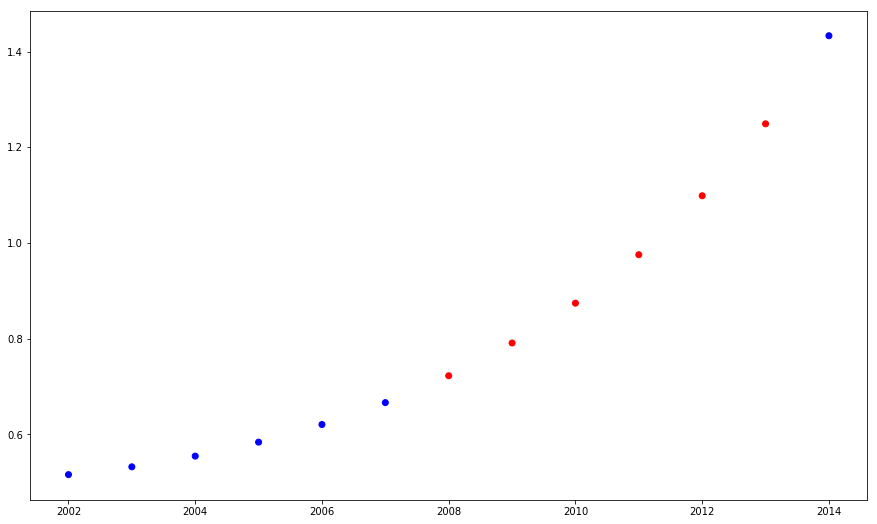

In [10]:
plt.scatter(x, y, color=xy_cmap)
plt.show()

In [11]:
# Save data for d3.js
print "year,lr,colour"
for xi, yi, ci in zip(x, y, xy_cmap):
    if ci == "red":
        print "%d,%f,%s" % (xi, yi, "r")
    else:
        print "%d,%f,%s" % (xi, yi, "b")

year,lr,colour
2002,0.515900,b
2003,0.532192,b
2004,0.554600,b
2005,0.583789,b
2006,0.620660,b
2007,0.666393,b
2008,0.722511,r
2009,0.790959,r
2010,0.874218,r
2011,0.975443,r
2012,1.098657,r
2013,1.248999,r
2014,1.433062,b


In [12]:
lr = llr

In [13]:
def delta_w(xy, year=None, learning_rate=None):
    def f(xy, lr):
        w_updates = []
        top_ordinal = len(xy)
        
        if top_ordinal == 1: # single author
            w_updates = (xy[0], xy[0], lr/2.0)
        else:
            ordinals = [(j, i+1) for i, j in enumerate(xy)]
            pairs = list(itertools.combinations(ordinals, 2))
            
            for (id1, i1), (id2, i2) in pairs:
                f_val = lr * 1#float(abs(i1-i2)) / top_ordinal
                w_updates.append( (id1, id2, f_val) )
        return w_updates
    
    if year is None:
        lr = 1.0
    else:
        if learning_rate is None:
            print "Error: learnign_rate cannot be None"
            return None
        
        if len(xy) == 1:
            lr = learning_rate[0]
        else:
            lr = learning_rate[year]


    return f(xy, lr)

In [14]:
global_norm = {} # number of deltas for each pair
def update_glob(tup):
    global global_norm
    if tup in global_norm:
        global_norm[tup] += 1
    else:
        global_norm[tup] = 1

for p in pub.iterrows():
    authors = p[1]["AUTHORS"]
    year = p[1]["PUBLICATION_YEAR"]
    
    w_local = delta_w(authors)
    if isinstance(w_local, tuple):
        connections_yearly[year][w_local[0]][w_local[1]] += w_local[2]
    else: # list
        for i in w_local:
            connections_yearly[year][i[0]][i[1]] += i[2]
            connections_yearly[year][i[1]][i[0]] += i[2]
    
    w_global = delta_w(authors, year, lr)
    if isinstance(w_global, tuple):
        connections_yearly["total"][w_global[0]][w_global[1]] += w_global[2]
        update_glob((w_global[0], w_global[1]))
    else: # list
        for i in w_global:
            connections_yearly["total"][i[0]][i[1]] += i[2]
            connections_yearly["total"][i[1]][i[0]] += i[2]
            update_glob((i[0], i[1]))

# Get name mapping #

In [253]:
# org_key = pd.read_pickle("org_key_pickle.pickle")
# dkg = {}
# for i in ttotal:
#     if i == "none":
#         continue
#     dkg[i] = org_key[org_key["ORGANISATION_CODE"] == i]["FULL_NAME"].values[0]
# dkg

## Linkage between departments ##

In [34]:
connections_yearly.keys()

['total', 2008, 2009, 2010, 2011, 2012, 2013]

In [358]:
total = connections_yearly["total"].copy()

In [359]:
# normalise total sum/N
# for i in global_norm:
#     total[i[0]][i[1]] /= global_norm[i]
#     total[i[1]][i[0]] /= global_norm[i]

In [360]:
# get original faculties
with open("facs_ppl.pickle", 'r') as pf:
    facs_ppl = pickle.load(pf)

faculties = pd.Series(index=total.index)
for i in faculties.index:
    ff = "none"
    for k in facs_ppl:
        if i in facs_ppl[k]:
            ff = k
            break
    faculties[i] = ff

# Get original schools    
with open("schls_ppl.pickle", 'r') as pf:
    schls_ppl = pickle.load(pf)
schools = pd.Series(index=total.index)
for i in schools.index:
    ff = "none"
    for k in schls_ppl:
        if i in schls_ppl[k]:
            ff = k
            break
    schools[i] = ff
# for f in facs_ppl:
#     for i in facs_ppl[f]:
#         faculties[i] = f
# for i in faculties[faculties.isnull()].index:
#     faculties[i] = "none"

In [361]:
for i in schls_ppl.keys()+["none"]:
    j = list(schools[schools == i].index)
    if j:
        total[i] = total[j].sum(axis=1) / float(len(j)) # normalise average
        total.drop(j, axis=1, inplace=True)
for i in schls_ppl.keys()+["none"]:
    j = list(schools[schools == i].index)
    if j:
        total.loc[i] = total.loc[j].sum(axis=0) / float(len(j)) # normalise average
        total.drop(j, axis=0, inplace=True)
# total

In [362]:
# Set up connections per year
# csv_con = {}
# for i in total:
#     for j, _ in total[i].iteritems():
#         csv_con[i+","+j] = {}
# for i in csv_con:
#     for j in years+["total"]:
#         csv_con[i][j] = 0.0
# csv_con

In [363]:
# for i in years:
#     print type(i)

In [364]:
# export to CSV -- manually for each year
# for i in total:
#     for ji, jj in total[i].iteritems():
#         csv_con[i+","+ji][2013] = jj

In [365]:
# csv_con

In [366]:
# s = "org1,org2,total,2008,2009,2010,2011,2012,2013\n"
# for i in csv_con:
#     s += i + ","
#     for j in csv_con[i]:
#         n = "%.10f" % csv_con[i][j]
#         s += n + ","
#     s = s[:-1]
#     s += "\n"
# with open("school_connections.csv", "w") as sc:
#     sc.write(s)

In [367]:
# Best internally connected schools -- scaled/unscaled
from pprint import pprint
inter_connect = []
for i in total:
    inter_connect.append((total.loc[i, i], i))
pprint( sorted(inter_connect)[::-1] )

[(0.31145429644687261, 'CHSE'),
 (0.20616706861491527, 'PSYC'),
 (0.15899048706346286, 'MVSF'),
 (0.15079268181051866, 'MODL'),
 (0.15023970825822838, 'GEOG'),
 (0.13289832424538442, 'SPOL'),
 (0.1158364748848391, 'EDUC'),
 (0.11443355707269466, 'PHYS'),
 (0.10761456518784325, 'LAWD'),
 (0.10227972150008907, 'ORDS'),
 (0.098330976873479706, 'GELY'),
 (0.098143003835111098, 'SPAI'),
 (0.082371611678062312, 'CHEM'),
 (0.076948846995546979, 'BISC'),
 (0.075557208029158038, 'MVEN'),
 (0.07230371325247345, 'VESC'),
 (0.071877973799514258, 'EFIM'),
 (0.070507146512853794, 'QUEN'),
 (0.069760500465791339, 'HUMS'),
 (0.067409958474535417, 'PHPH'),
 (0.067192743950753753, 'SART'),
 (0.060018478718172515, 'MATH'),
 (0.054761454726992544, 'BIOC'),
 (0.05055168767992798, 'PANM'),
 (0.03581144334589028, 'SSCM'),
 (0.025101115488122203, 'SOCS'),
 (0.0028893011291849357, 'MEED'),
 (0.0027589739484525115, 'none'),
 (0.0, 'SCIF'),
 (0.0, 'NSQI'),
 (0.0, 'MSAD'),
 (0.0, 'MDYF'),
 (0.0, 'LANG'),
 (0.0, '

In [368]:
with open("fac_schls.pickle", 'r') as pf:
    fac_sch = pickle.load(pf)

# Best externally connected schools -- LOOK MORE INTO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!
for i in total:
    # this depends on the cell below
    if i == "none":
        neighbours = list(total.index)[:]
        neighbours.remove("none")
    else:
        neighbours = None
    for f in fac_sch:
        if i in fac_sch[f]:
            neighbours = fac_sch[f][:]
            neighbours.remove(i)
            break
    #
    j = total[i].copy()
    j.sort()
    o = list(j[j != 0].index)[::-1]
    if i in o:
        o.remove(i)
    #
    tops = min(len(neighbours), len(o))
    t = 0
    for j in range(tops):
        if o[j] in neighbours:
            t += 1
    #
    print t, "of", tops, "(total neighbours", len(neighbours), ")"
    print i,  "-->", o

0 of 3 (total neighbours 5 )
INOV --> ['MVEN', 'PSYC', 'QUEN']
0 of 1 (total neighbours 4 )
CABI --> ['SSCM']
3 of 4 (total neighbours 4 )
MVSF --> ['BIOC', 'PHPH', 'PANM', 'SOCS', 'PHYS', 'BISC', 'CHEM', 'VESC']
2 of 3 (total neighbours 3 )
ENGF --> ['MVEN', 'MSAD', 'QUEN', 'EDUC', 'none', 'SSCM', 'VESC', 'SOCS']
1 of 6 (total neighbours 6 )
VESC --> ['CHSE', 'EDUC', 'BISC', 'PANM', 'MVSF', 'ENGF', 'HUMS', 'SART', 'MATH', 'LAWD', 'SOCS', 'BIOC', 'SSCM', 'PHPH', 'GELY', 'none', 'QUEN', 'MVEN']
1 of 8 (total neighbours 8 )
PSYC --> ['INOV', 'SSCM', 'BISC', 'SOCS', 'PHPH', 'EFIM', 'ORDS', 'MEED', 'EDUC', 'QUEN', 'none', 'MVEN', 'CHEM']
4 of 8 (total neighbours 8 )
CHEM --> ['SCIF', 'none', 'MODL', 'SART', 'GEOG', 'PANM', 'GELY', 'PHYS', 'BIOC', 'MATH', 'MVSF', 'ORDS', 'MEED', 'BISC', 'QUEN', 'SSCM', 'SOCS', 'MVEN', 'PSYC', 'PHPH', 'EDUC']
0 of 1 (total neighbours 5 )
LANG --> ['SOCS']
4 of 4 (total neighbours 4 )
BIOC --> ['MVSF', 'PHPH', 'PANM', 'MSAD', 'CHEM', 'SOCS', 'MVEN', 'GEOG', '

/Users/kacper/.virtualenvs/py2-data/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [369]:
pprint(fac_sch)
    
ttotal = total.copy()
    
for i in fac_sch:
    j = []
    for k in fac_sch[i]:
        if k in ttotal:
            j.append(k)
    if j:
#         print ttotal[j].sum(axis=1)
        ttotal[i] = ttotal[j].sum(axis=1) #/ float(len(j)) # normalise average
        ttotal.drop(j, axis=1, inplace=True)
for i in fac_sch:
    j = []
    for k in fac_sch[i]:
        if k in list(ttotal.index):
            j.append(k)
    if j:
        ttotal.loc[i] = ttotal.loc[j].sum(axis=0) #/ float(len(j)) # normalise average
        ttotal.drop(j, axis=0, inplace=True)
ttotal

{'FENG': ['ENGF', 'QUEN', 'MVEN', 'GSEN'],
 'FLAW': ['LAWF', 'PLEG'],
 'FMDY': ['VESC', 'ORDS', 'MEED', 'MDYF', 'SSCM', 'SOCS', 'CHSE'],
 'FMED': ['MEDF',
          'EPID',
          'ANHU',
          'VSUR',
          'ETOX',
          'HOSP',
          'PATH',
          'VMED',
          'MICB'],
 'FMVS': ['BIOC', 'PANM', 'MVSF', 'MSAD', 'PHPH'],
 'FOAT': ['MODL', 'ARTF', 'SART', 'HUMS', 'LANG', 'INOV'],
 'FSCI': ['PSYC',
          'GEOG',
          'GELY',
          'CHEM',
          'MATH',
          'BISC',
          'NSQI',
          'SCIF',
          'PHYS'],
 'FSOC': ['SOCF', 'MBAI', 'CCSS', 'HEAG'],
 'FSSL': ['SPOL',
          'SOCI',
          'LAWD',
          'POLI',
          'EDUC',
          'SSLF',
          'EFIM',
          'ACHS',
          'POLP',
          'CEAS',
          'SPAI'],
 'INST': ['IAST', 'EBIN', 'BRIG', 'JGIN', 'CABI']}


,none,FENG,FMDY,FSCI,FOAT,INST,FMVS,FSSL
none,0.002759,0.015155,0.002987,0.010226,0.000634,0.000000,0.000956,0.003170
FENG,0.015155,0.315877,0.003622,0.013924,0.027488,0.000000,0.023377,0.005426
FMDY,0.002987,0.003622,1.329661,0.022044,0.010081,0.004322,0.052193,0.019655
FSCI,0.010226,0.013924,0.022044,0.968561,0.033920,0.000000,0.019691,0.013175
FOAT,0.000634,0.027488,0.010081,0.033920,0.326766,0.000000,0.000000,0.009141
INST,0.000000,0.000000,0.004322,0.000000,0.000000,0.000000,0.000000,0.000000
FMVS,0.000956,0.023377,0.052193,0.019691,0.000000,0.000000,0.512671,0.000000
FSSL,0.003170,0.005426,0.019655,0.013175,0.009141,0.000000,0.000000,0.542685


In [370]:
# csv_con = {}
# for i in ttotal:
#     for j, _ in ttotal[i].iteritems():
#         csv_con[i+","+j] = {}
# for i in csv_con:
#     for j in years+["total"]:
#         csv_con[i][j] = 0.0
# csv_con

In [371]:
# save to csv -- chord plot
for i in ttotal:
    for ji, jj in ttotal[i].iteritems():
        csv_con[i+","+ji]["total"] = jj

In [376]:
# s = "org1,org2,total,2008,2009,2010,2011,2012,2013\n"
# for i in csv_con:
#     s += i + ","
#     for j in csv_con[i]:
#         print j
#         n = "%.10f" % csv_con[i][j]
#         s += n + ","
#     s = s[:-1]
#     s += "\n"
# with open("faculties_connections.csv", "w") as sc:
#     sc.write(s)

In [373]:
# Best internally connected faculties -- unscaled
inter_connect_fac = []
for i in ttotal:
    inter_connect_fac.append((ttotal.loc[i, i], i))
pprint( sorted(inter_connect_fac)[::-1] )

[(1.3296612083778108, 'FMDY'),
 (0.96856124208796734, 'FSCI'),
 (0.54268544124219975, 'FSSL'),
 (0.5126714675140257, 'FMVS'),
 (0.3267664867753553, 'FOAT'),
 (0.31587679462849272, 'FENG'),
 (0.0027589739484525115, 'none'),
 (0.0, 'INST')]


In [374]:
# Best externally connected faculties
for i in ttotal:
    j = ttotal[i].copy()
    j.sort()
    print i, "-->", j.index[-1], "-->", j.index[-2], "-->", j.index[-3]

none --> FENG --> FSCI --> FSSL
FENG --> FENG --> FOAT --> FMVS
FMDY --> FMDY --> FMVS --> FSCI
FSCI --> FSCI --> FOAT --> FMDY
FOAT --> FOAT --> FSCI --> FENG
INST --> FMDY --> FSSL --> FMVS
FMVS --> FMVS --> FMDY --> FENG
FSSL --> FSSL --> FMDY --> FSCI


/Users/kacper/.virtualenvs/py2-data/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  after removing the cwd from sys.path.


# Hierarchical clustering on total collaboraitons

In [377]:
total_hier = total.copy()

# drop acad offices
acad_offices = ["ENGF","ARTF","MVSF","MDYF","SSLF","LAWF","SOCF","MEDF","SCIF"]
acad_office_pres = []
for i in acad_offices:
    if i in total_hier:
        acad_office_pres.append(i)
total_hier.drop(acad_office_pres, axis=1, inplace=True)
total_hier.drop(acad_office_pres, axis=0, inplace=True)
total_hier

,INOV,CABI,VESC,PSYC,CHEM,LANG,BIOC,EDUC,PHPH,LAWD,...,NSQI,ORDS,QUEN,SOCS,SART,MEED,BISC,MATH,GELY,none
INOV,0.000000,0.000000,0.000000,0.015373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.005907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CABI,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VESC,0.000000,0.000000,0.072304,0.000000,0.000000,0.000000,0.000274,0.004208,0.000179,0.000331,...,0.000000,0.000000,0.000086,0.000307,0.000466,0.000000,0.003125,0.000341,0.000125,0.000118
PSYC,0.015373,0.000000,0.000000,0.206167,0.000139,0.000000,0.000000,0.001093,0.002257,0.000000,...,0.000000,0.001556,0.000852,0.002319,0.000000,0.001132,0.002761,0.000000,0.000000,0.000555
CHEM,0.000000,0.000000,0.000000,0.000139,0.082372,0.000000,0.002172,0.000111,0.000118,0.000000,...,0.000000,0.001288,0.000288,0.000234,0.004376,0.000645,0.000557,0.001955,0.003295,0.006502
LANG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.003586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BIOC,0.000000,0.000000,0.000274,0.000000,0.002172,0.000000,0.054761,0.000000,0.003099,0.000000,...,0.000000,0.000260,0.000000,0.001682,0.000000,0.000303,0.000680,0.000596,0.000000,0.000000
EDUC,0.000000,0.000000,0.004208,0.001093,0.000111,0.000000,0.000000,0.115836,0.000000,0.000000,...,0.000000,0.000000,0.000127,0.000396,0.000000,0.003562,0.001918,0.000000,0.000000,0.001033
PHPH,0.000000,0.000000,0.000179,0.002257,0.000118,0.000000,0.003099,0.000000,0.067410,0.000000,...,0.000000,0.000415,0.000000,0.002977,0.000000,0.000201,0.001466,0.000631,0.000000,0.000185
LAWD,0.000000,0.000000,0.000331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107615,...,0.000000,0.000812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [380]:
# check how many zeros out of 33
non_zreo_schools = {}
for i in total_hier:
    j = total_hier[i]
    non_zreo_schools[i] = j[j !=0].count()
zero_med = np.median(non_zreo_schools.values())
print zero_med
med_mul = 1.1
zero_med *= med_mul

remove_near_zero = []
for i in non_zreo_schools:
    if non_zreo_schools[i] < zero_med:
        remove_near_zero.append(i)

total_hier.drop(remove_near_zero, axis=1, inplace=True)
total_hier.drop(remove_near_zero, axis=0, inplace=True)
total_hier   

14.0


,VESC,CHEM,PHYS,MVEN,SSCM,QUEN,SOCS,BISC,MATH,none
VESC,0.072304,0.000000,0.000000,0.000054,0.000219,0.000086,0.000307,0.003125,0.000341,0.000118
CHEM,0.000000,0.082372,0.003015,0.000208,0.000247,0.000288,0.000234,0.000557,0.001955,0.006502
PHYS,0.000000,0.003015,0.114434,0.003714,0.000100,0.001176,0.000140,0.000600,0.003246,0.001286
MVEN,0.000054,0.000208,0.003714,0.075557,0.000000,0.005400,0.000245,0.002162,0.001547,0.005587
SSCM,0.000219,0.000247,0.000100,0.000000,0.035811,0.000054,0.003662,0.000421,0.000892,0.001201
QUEN,0.000086,0.000288,0.001176,0.005400,0.000054,0.070507,0.000039,0.000092,0.000494,0.007497
SOCS,0.000307,0.000234,0.000140,0.000245,0.003662,0.000039,0.025101,0.000092,0.000195,0.000708
BISC,0.003125,0.000557,0.000600,0.002162,0.000421,0.000092,0.000092,0.076949,0.010872,0.000255
MATH,0.000341,0.001955,0.003246,0.001547,0.000892,0.000494,0.000195,0.010872,0.060018,0.000278
none,0.000118,0.006502,0.001286,0.005587,0.001201,0.007497,0.000708,0.000255,0.000278,0.002759


/Users/kacper/.virtualenvs/py2-data/lib/python2.7/site-packages/ipykernel_launcher.py:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  from ipykernel import kernelapp as app


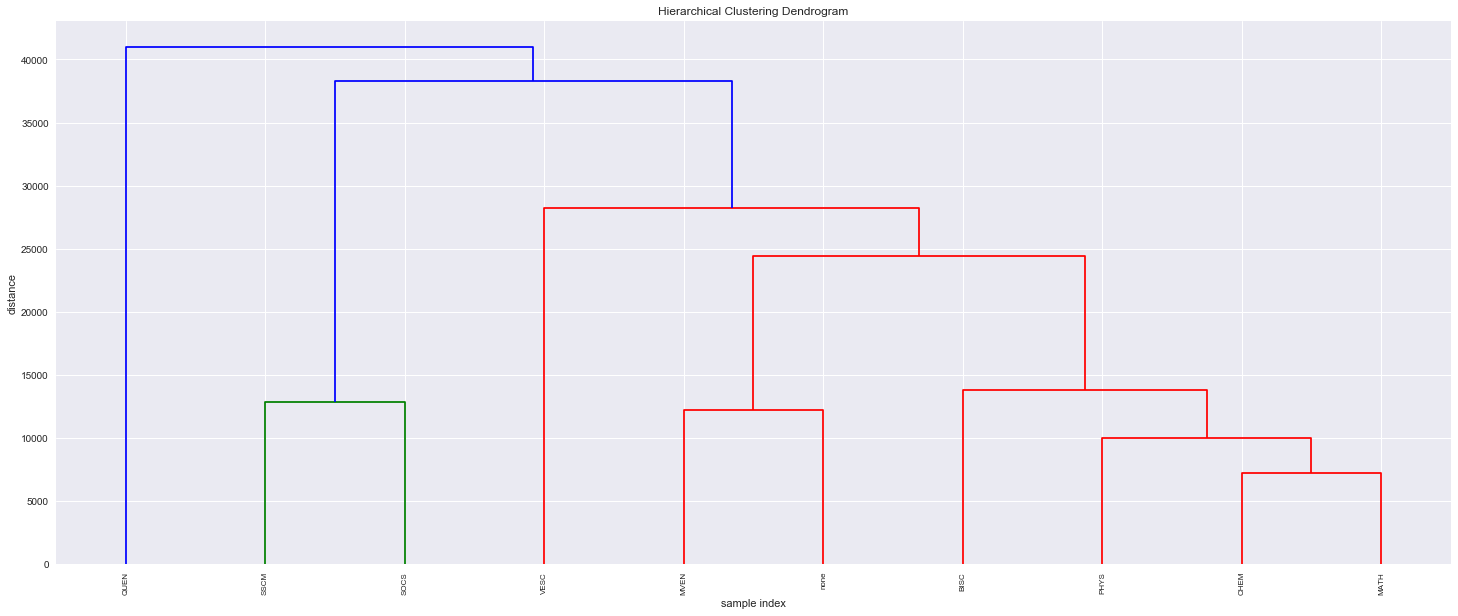

In [187]:
th_max = 1.1 * total_hier.max(axis=0).max()
for i in total_hier:
    for j in total_hier:
        if total_hier[i][j] == 0:
            total_hier[i][j] = 1.0
        else:
            total_hier[i][j] = 1.0 / total_hier[i][j]
#         total_hier[i][j] = th_max - total_hier[i][j]
for i in total_hier:
    total_hier[i][i] = 0.0

from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

Z = linkage(total_hier.as_matrix(), 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    labels=list(total_hier.index),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
# plt.show()
plt.savefig("test.png", figsize=(8, 6), dpi=200)
    
#     import operator
# # A list of pairwise distances
# pd = {}
# for i in total_hier:
#     for j in total_hier[i].index:
#         if i == j:
#             continue
#         if (i, j) in pd:
#             pass
#         elif (j, i) in pd:
#             pass
#         else:
#             pd[(i, j)] = total_hier[i][j]
            
# for i in pd.keys():
#     if pd[i] == 0:
#         del pd[i]

# def linkage(s):
#     return s

# pd
# Z = []
# while pd:
#     max_value = max(pd.iteritems(), key=operator.itemgetter(1))[0]
#     Z.append((max_value[0], max_value[1], ))
#     # del pd[max_value]

# Network analysis

In [381]:
net = total.copy()
import networkx as nx
G = nx.from_numpy_matrix(net.as_matrix())

In [382]:
Gl = {}
for i, j in enumerate(list(net.index)):
    Gl[i] = j

H=nx.relabel_nodes(G,Gl)

In [383]:
# H.edge

In [386]:
import operator
# H.degree()
# nx.clustering(H)

# ss = nx.betweenness_centrality(H)
# ss= nx.closeness_centrality(H)
ss = nx.eigenvector_centrality(H)
sorted(ss.items(), key=operator.itemgetter(1))[::-1]

[('ORDS', 0.686510276856787),
 ('MDYF', 0.5952796892841816),
 ('CHSE', 0.4058676951586213),
 ('SSCM', 0.08751883805751973),
 ('MEED', 0.02775775592965796),
 ('MSAD', 0.027254919505048634),
 ('SOCS', 0.011327582604037524),
 ('PSYC', 0.010367241254086444),
 ('VESC', 0.00733613413107003),
 ('SPOL', 0.006079173090563653),
 ('PANM', 0.005416988165039459),
 ('PHYS', 0.0049991937931702065),
 ('SART', 0.00452736615404328),
 ('CHEM', 0.0037678547840302324),
 ('LAWD', 0.0025447799289948256),
 ('ENGF', 0.002018009694576922),
 ('QUEN', 0.001997609253225904),
 ('none', 0.001818336189379822),
 ('PHPH', 0.0017997563144991255),
 ('BIOC', 0.0011753440035455148),
 ('BISC', 0.0011204682521621448),
 ('MVSF', 0.0010849131779781449),
 ('CABI', 0.0010823458333302119),
 ('EDUC', 0.0008255465663381217),
 ('HUMS', 0.0005469618719302574),
 ('MVEN', 0.0005375956207882405),
 ('INOV', 0.0005221598825505804),
 ('MATH', 0.0005093327622858427),
 ('EFIM', 0.0004817432555930153),
 ('GEOG', 0.00047659026186641943),
 ('NS

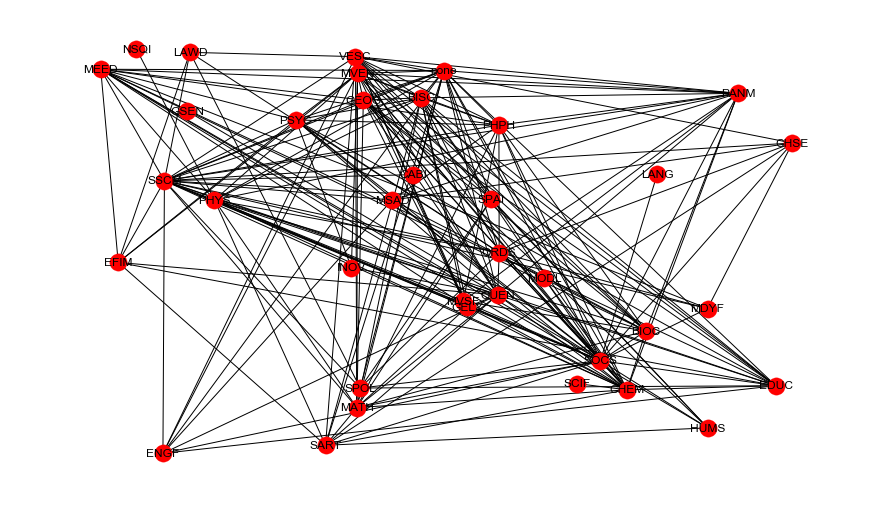

In [279]:
# nx.draw_networkx(H)

lay = nx.drawing.random_layout(H)
# lay = nx.drawing.shell_layout(H)
# lay = nx.drawing.circular_layout(H)
# lay = nx.drawing.spring_layout(H)
# lay = nx.drawing.spectral_layout(H)
nx.draw_networkx_labels(H, lay)
nx.draw(H, lay)

# Classical clusteirng doesn't work!!!

In [62]:
total = connections_yearly["total"].copy()

In [63]:
# normalise total sum/N
for i in global_norm:
    total[i[0]][i[1]] /= global_norm[i]
    total[i[1]][i[0]] /= global_norm[i]

37
37
100.0


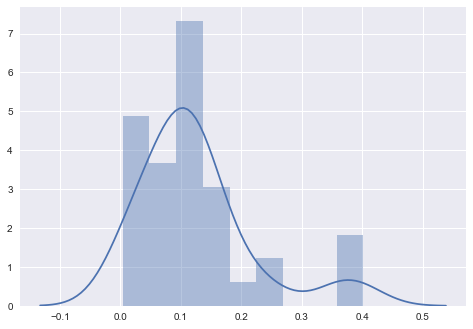

In [111]:
import seaborn as sns
keep = []
h = []
c = 0
t = 0
for i in total:
    s = total[i].sum()
    t += 1
    if s > 0 and s < 10000:
        c += 1
        keep.append(i)
        h.append(s)
print t
print c
print c*100.0/t
sns.distplot(h)

In [70]:
keep

[20,
 33,
 83,
 103,
 104,
 105,
 132,
 185,
 189,
 193,
 204,
 238,
 315,
 330,
 348,
 351,
 405,
 410,
 412,
 468,
 484,
 564,
 575,
 607,
 708,
 723,
 740,
 769,
 897,
 908,
 922,
 936,
 970,
 991,
 1170,
 1172,
 1186,
 1191,
 1192,
 1225,
 1252,
 1261,
 1317,
 1373,
 1399,
 1412,
 1414,
 1425,
 1631,
 1681,
 1682,
 1719,
 1866,
 1881,
 1885,
 1909,
 1968,
 1976,
 2058,
 2119,
 2169,
 2170,
 2175,
 2188,
 2223,
 2281,
 2392,
 2417,
 2421,
 2492,
 2572,
 2617,
 2685,
 2702,
 2707,
 2711,
 2760,
 2773,
 2823,
 2885,
 2897,
 2944,
 2973,
 2983,
 2995,
 3037,
 3100,
 3126,
 3151,
 3154,
 3232,
 3325,
 3551,
 3968,
 4041,
 4089,
 4118,
 4248,
 4399,
 4513,
 4515,
 4516,
 4545,
 4594,
 4839,
 4867,
 4964,
 5000,
 5001,
 5061,
 5116,
 5208,
 5300,
 5301,
 5448,
 5470,
 5523,
 5597,
 5682,
 5759,
 5766,
 5831,
 5977,
 6028,
 6031,
 6059,
 6326,
 6350,
 6848,
 6851,
 6863,
 6892,
 6909,
 6968,
 7027,
 7086,
 7150,
 7192,
 7203,
 7214,
 7280,
 7414,
 7483,
 7543,
 7562,
 7658,
 7673,
 7682,
 

In [71]:
total = total.loc[keep, keep]

In [72]:
# total

In [105]:
# get inverted distances
t_max =  max(max(total.max(0)), max(total.max(1)))
print t_max
t_max = 1.1 * t_max

def total_inv(d):
    global t_max
#     return t_max - d
    if d == 0:
        return t_max
    else:
        return t_max - d

total = total.applymap(total_inv)

# set diagonal elements to 0.0
for i in total:
    total[i][i] = 0.0

0.311454296447


In [106]:
# for i in total:
#     print total[i].sum()
#     break
total

,INOV,CABI,MVSF,ENGF,VESC,PSYC,CHEM,LANG,BIOC,EDUC,...,ORDS,QUEN,SOCS,SART,SCIF,MEED,BISC,MATH,GELY,none
INOV,0.000000,0.342600,0.342600,0.342600,0.342600,0.327227,0.342600,0.342600,0.342600,0.342600,...,0.342600,0.336693,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600
CABI,0.342600,0.000000,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,...,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600
MVSF,0.342600,0.342600,0.000000,0.342600,0.341467,0.342600,0.341059,0.342600,0.306081,0.342600,...,0.342600,0.342600,0.337737,0.342600,0.342600,0.342600,0.340450,0.342600,0.342600,0.342600
ENGF,0.342600,0.342600,0.342600,0.000000,0.341810,0.342600,0.342600,0.342600,0.342600,0.338056,...,0.342600,0.327872,0.341844,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.340528
VESC,0.342600,0.342600,0.341467,0.341810,0.000000,0.342600,0.342600,0.342600,0.342325,0.338392,...,0.342600,0.342514,0.342292,0.342133,0.342600,0.342600,0.339475,0.342259,0.342474,0.342481
PSYC,0.327227,0.342600,0.342600,0.342600,0.342600,0.000000,0.342461,0.342600,0.342600,0.341506,...,0.341044,0.341748,0.340281,0.342600,0.342600,0.341468,0.339839,0.342600,0.342600,0.342044
CHEM,0.342600,0.342600,0.341059,0.342600,0.342600,0.342461,0.000000,0.342600,0.340428,0.342488,...,0.341312,0.342311,0.342365,0.338223,0.328041,0.341954,0.342043,0.340645,0.339305,0.336098
LANG,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.000000,0.342600,0.342600,...,0.342600,0.342600,0.339014,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600,0.342600
BIOC,0.342600,0.342600,0.306081,0.342600,0.342325,0.342600,0.340428,0.342600,0.000000,0.342600,...,0.342339,0.342600,0.340917,0.342600,0.342600,0.342297,0.341920,0.342003,0.342600,0.342600
EDUC,0.342600,0.342600,0.342600,0.338056,0.338392,0.341506,0.342488,0.342600,0.342600,0.000000,...,0.342600,0.342473,0.342203,0.342600,0.342600,0.339038,0.340682,0.342600,0.342600,0.341566


In [75]:
# total.to_csv("distance_mx.csv")

## classical clustering 
TODO: check wheter it's working as expected

it seems that you cannot cluster by people even after normalisation

In [76]:
import hdbscan

In [107]:
# distance_matrix = pairwise_distances(blobs)
clusterer = hdbscan.HDBSCAN(metric='precomputed')#, min_cluster_size=15, alpha=0.1)
clusterer.fit(total)
labeling = pd.Series(clusterer.labels_, index=total.index)

# lf = pd.DataFrame({"label":labeling, "faculty":faculties})

print len(clusterer.labels_)
print max(clusterer.labels_)

37
-1


In [99]:
llf = lf[lf["label"] != -1]

In [100]:
sklearn.metrics.adjusted_rand_score(llf["label"], llf["faculty"])

0.0045487501593601013

In [334]:
from collections import Counter
print Counter(llf[llf["label"] == 2]["faculty"].values)

Counter()


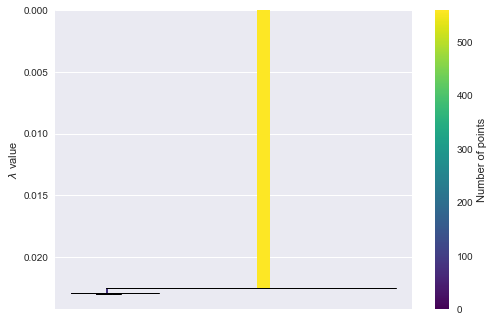

In [282]:
clusterer.condensed_tree_.plot()

In [192]:
# get a regular grid
no_points = len(total)
print no_points
print math.ceil(math.sqrt(no_points))
print 58**2

3263
58.0
3364


20       FMVS
33       FSSL
44       FENG
57       FMVS
77       FSCI
83       FMDY
94       FSCI
103      FSCI
104      FMDY
105      FMDY
132      FENG
153      FSCI
177      FSCI
178      FOAT
184      FSCI
185      FMVS
189      FMDY
193      FSCI
204      FSCI
238      FENG
302      FSCI
315      FSSL
321      FOAT
330      FMVS
348      FSSL
351      FENG
379      FOAT
405      FSSL
410      FMVS
412      none
         ... 
67163    FSCI
67284    none
67324    FOAT
67327    FOAT
67342    FMVS
67421    FMDY
67525    FMDY
67601    FMVS
67631    FSSL
67744    FMDY
67761    FOAT
67762    FOAT
67803    FOAT
67805    FSCI
68046    FSSL
68289    FOAT
68303    FOAT
68466    FMVS
68664    FOAT
68901    FSCI
69206    FMVS
69281    FMVS
69402    FSCI
69445    FSCI
69695    FENG
69968    FOAT
70090    FMDY
70344    FMDY
70563    FENG
70581    FENG
dtype: object

In [194]:
labels = sorted(list(set(clusterer.labels_)))

cmap = matplotlib.cm.get_cmap('Spectral')
label_cmap = {}
cmap_normalizer = matplotlib.colors.Normalize(vmin=float(min(labels)), vmax=float(max(labels)))
for l in labels:
    label_cmap[l] = cmap_normalizer(l)

In [195]:
grid_spaces = []
for i in range(1, 59):
    for j in range(1, 59):
        grid_spaces.append((i, j))
grid_spaces = grid_spaces[::-1]

In [196]:


facs_map = {
 'FENG': 'o',
 'FSOC': 'v',
 'FMDY': '^',
 'FMED': '<',
 'FLAW': '>',
 'FSCI': '8',
 'FOAT': 's',
 'INST': 'p',
 'FMVS': '*',
 'FSSL': 'h',
 'none': 'H'
}

In [197]:
total_grided = pd.DataFrame(index=total.index, columns=["x", "y", "label", "faculty"])
# for i in labels:
#     for j in total[total["label"] == i].index:
#         place = grid_spaces.pop()
#         total_grided["x"][j] = place[0]
#         total_grided["y"][j] = place[1]
#         total_grided["label"][j] = label_cmap[i]
#         fac = "none"
#         for f in facs_ppl:
#             if j in facs_ppl[f]:
#                 fac = f
#                 break
#         total_grided["faculty"][j] = facs_map[fac]



for f in facs_ppl:
    for i in facs_ppl[f]:
        total_grided["faculty"][i] = facs_map[f]
        place = grid_spaces.pop()
        total_grided["x"][i] = place[0]
        total_grided["y"][i] = place[1]
        total_grided["label"][i] = label_cmap[total["label"][i]]
for i in total_grided[total_grided["faculty"].isnull()].index:
    total_grided["faculty"][i] = facs_map["none"]
    place = grid_spaces.pop()
    total_grided["x"][i] = place[0]
    total_grided["y"][i] = place[1]
    total_grided["label"][i] = label_cmap[total["label"][i]]

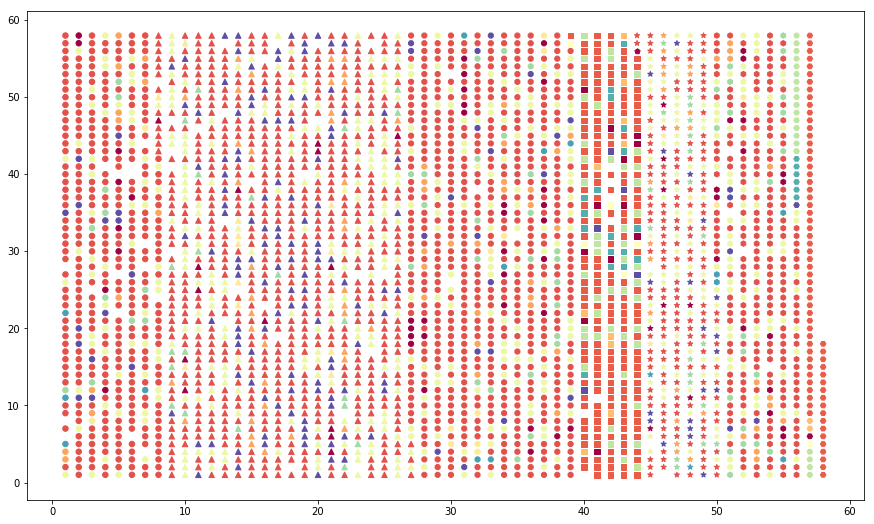

In [198]:
plt.figure(1)
for m in list(set(total_grided["faculty"].values)):
    pt = total_grided[total_grided["faculty"] == m]
    plt.scatter(pt["x"].values, pt["y"].values, \
                c=pt["label"].values, marker=m, \
                s=30, cmap=cmap)

plt.show()

In [215]:
# total_grided[total_grided["label"] == 0].count()
print total_grided[total_grided["faculty"] != "none"].count()
print len(total_grided)

x          3263
y          3263
label      3263
faculty    3263
dtype: int64
3263


In [216]:
# clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

In [217]:
total[total["label"] == 5]["label"].count()

22

In [115]:
lilo = pd.Series([1.0,2,3,0,0])
lilo[lilo != 0].count()

3